# This notebook is used for generating example cases with synthetic paleomagnetic APWPs demonstrating the Bayesian_PEP_inversion package

The code is adjusted from Ian Rose's mcplates package: https://github.com/ian-r-rose/mcplates

In [1]:
from bayesian_pep import *
# theano.config.floatX = 'float64'

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
d2r = np.pi/180
r2d = 180/np.pi
eps = 1.e-6

## One Euler pole inversion

In [4]:
def generate_APWP_pole(start_pole, start_age, end_age, euler_pole, euler_rate):
    # this function generates synthetic APWP poles by calculating end pole positions given a start pole position and age, 
    # desired end age, euler rotation pole position and rate
    # calculates end pole position by rotating the start pole with angle = age difference * rotation rate
    
    # all poles should be given in directions, they will be calculated into cartesian coordinates
    
#     if end_age < start_age:
#         raise Exception('end age younger than start age! try change sign of euler rate! ')
        
    start_pole_cart = pmag.dir2cart(start_pole)[0]
    euler_pole_cart = pmag.dir2cart(euler_pole)[0]
    
    age_diff = np.abs(end_age - start_age)
    
    end_pole = rotate(start_pole_cart,euler_pole_cart,age_diff*euler_rate)
    
    return pmag.cart2dir(end_pole)[0][:2]


In [5]:
def plot_paleomagnetic_poles(dataframe, central_longitude=0, central_latitude=0, **kwargs):
    ax = ipmag.make_orthographic_map(central_longitude, central_latitude, **kwargs)

    ax.set_global()
    ax.gridlines()
    
    cNorm  = matplotlib.colors.Normalize(vmin=min(dataframe['pole_age']), vmax=max(dataframe['pole_age']))
    scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap='viridis_r')

    dataframe['color'] = [colors.rgb2hex(scalarMap.to_rgba(dataframe['pole_age'].tolist()[i])) for i in range(dataframe.shape[0])]

    for i in range(dataframe .shape[0]):
        this_pole = Pole(dataframe['pole_lon'][i], dataframe['pole_lat'][i], A95 = dataframe['pole_a95'][i])
        this_pole.plot(ax, color = dataframe['color'][i])
        
    cbar = plt.colorbar(scalarMap)
    
    return ax

### generate synthetic poles

In [74]:
euler_pole = [0,0]
euler_rate = 2. 
ages = [60, 40, 20, 0]

pole0 = [38, 19.8]
pole1 = generate_APWP_pole(pole0, ages[0], ages[1], [0,0], euler_rate)
pole2 = generate_APWP_pole(pole0, ages[0], ages[2], [0,0], euler_rate)
pole3 = generate_APWP_pole(pole0, ages[0], ages[3], [0,0], euler_rate)

poles = np.array([pole0, pole1, pole2, pole3])
         
lons = poles.T[0]
lats = poles.T[1]

a95s = [5.5,5.5,5.5,5.5]

one_euler_data = pd.DataFrame(data = np.array([lons, lats, ages, a95s]).T, columns = ['pole_lon', 'pole_lat', 'pole_age', 'pole_a95'])
one_euler_data

pole_lon   pole_lat  pole_age  pole_a95
0   38.000000  19.800000      60.0       5.5
1   16.952592  39.185418      40.0       5.5
2  342.553897  38.997387      20.0       5.5
3  321.821751  19.407732       0.0       5.5

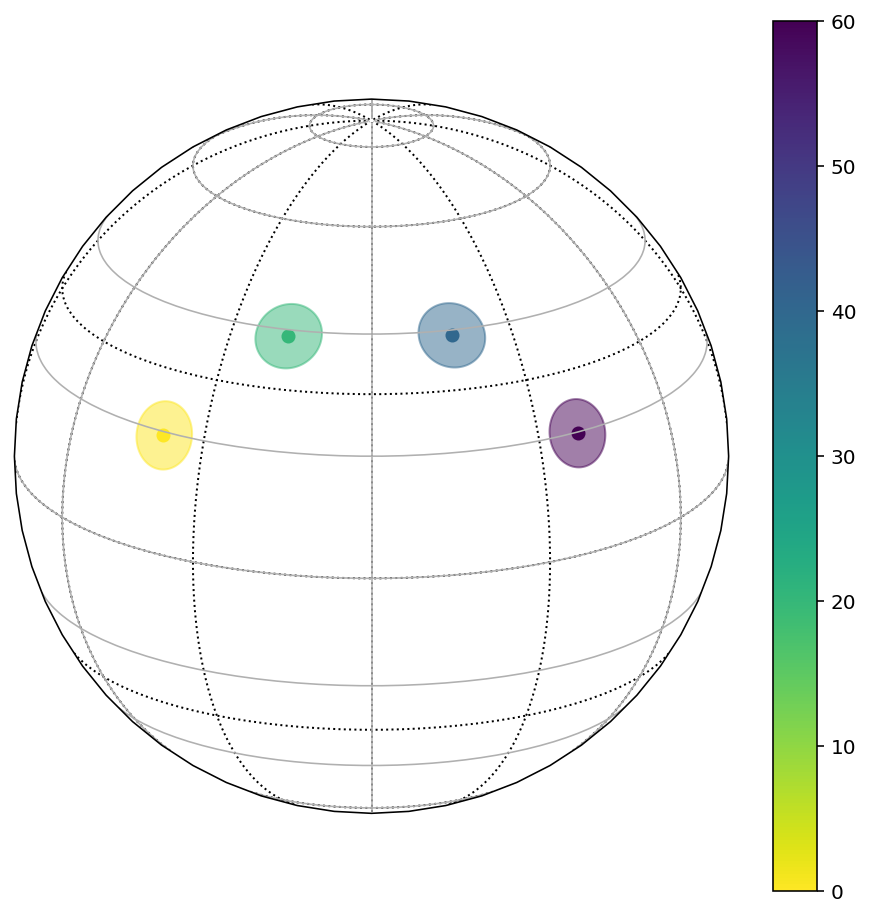

In [75]:
plot_paleomagnetic_poles(one_euler_data, central_latitude=20, add_land=0);

### invert for the Euler poles and Euler rates

theano.config.floatX = 'float64'

with pm.Model() as model:

    euler_1 = VMF('euler_1', lon_lat = [1.,0.,], k = 1., testval = np.array([1., 0.]), shape = 2)
    rate_1 = pm.Exponential('rate_1', 2.5) 
    
    start = VMF('start', lon_lat=lon_lats[0], k = kappa_from_two_sigma(10.), testval = np.array([1., 0.]), shape = 2)


    for i in range(len(ages)):
        time = pm.Normal('t'+str(i), mu=ages[i], tau=sigma_ages[i])
#         lon_lat = pm.DensityDist('ll'+str(i), lambda placehoder = 0., st=start, e1=euler_1, r1=rate_1, e2=euler_2, r2=rate_2, sw=switchpoint, t=time : pole_position(st, e1, r1, e2, r2, sw, t))
        lon_lat = pole_position_1e(start, euler_1, rate_1, time )

        observed_pole = VMF('p'+str(i), lon_lat, k = kappa_from_two_sigma(10.), observed=lon_lats[i])
    trace = pm.sample(2000, step = pm.Metropolis(), compute_convergence_checks=False, cores=1)

In [85]:
@as_op(itypes=[T.dvector, T.dvector, T.dscalar, T.dscalar, T.dscalar], otypes=[T.dvector])
def pole_position_1e( start, euler_1, rate_1, start_age, age ):
    
    start_pole = PaleomagneticPole(start[0], start[1], age=start_age)
    
    euler_pole_1 = EulerPole( euler_1[0], euler_1[1], rate_1)
    

    start_pole.rotate(euler_pole_1, euler_pole_1.rate*(start_age-age))

    lon_lat = np.array([start_pole.longitude, start_pole.latitude])

    return lon_lat

In [88]:
with pm.Model() as model:

    euler_1 = Watson_Girdle('euler_1', lon_lat = [1.,1.,], k = -1., testval = np.array([1., 1.]), shape = 2)
    rate_1 = pm.Uniform('rate_1', 0, 4) 
    
    start_age = pm.Normal('start_pole_age', one_euler_data['pole_age'].max(), 0.1)
    print('starting pole age is: ', str(one_euler_data['pole_age'].max()))
    
    start_index = start_pole_age = one_euler_data['pole_age'].argmax()
    
    start_lon_lat = [one_euler_data['pole_lon'].tolist()[start_index], one_euler_data['pole_lat'].tolist()[start_index]]
    start_k = kappa_from_two_sigma(one_euler_data['pole_a95'].tolist()[start_index])
    
    start = VMF('start_pole', lon_lat=start_lon_lat, 
                k = start_k, testval = np.array([1., 1.]), shape = 2)
    
    print('starting pole lon/lat:', start_lon_lat, 'starting pole k: ',start_k)
    
    
    
    for j in range(one_euler_data.shape[0]-1):
        i = j + 1
        age = pm.Normal('t'+str(i), mu=one_euler_data['pole_age'][i], sigma=0.1)
        print('pole '+str(i)+' age: ',one_euler_data['pole_age'][i])
        
#         euler_pole_1 = EulerPole(euler_1[0], euler_1[1], rate_1)
#         start_pole = PaleomagneticPole(start[0], start[1], age=one_euler_data['pole_age'].tolist()[-1])
        lon_lat = pole_position_1e(start, euler_1, rate_1, start_age, age)

#         observed_pole = VMF('p'+str(i), lon_lat, k = kappa_from_two_sigma(one_euler_data['pole_a95'].tolist()[i]), 
#                             observed=[one_euler_data['pole_lon'].tolist()[i], one_euler_data['pole_lat'].tolist()[i]])
        observed_pole = VMF('p'+str(i), lon_lat, k = kappa_from_two_sigma(one_euler_data['pole_a95'].tolist()[i]), 
                            observed=[one_euler_data['pole_lon'].tolist()[i], one_euler_data['pole_lat'].tolist()[i]])
        
    trace = pm.sample(10000, step = pm.Metropolis(), compute_convergence_checks=1, cores=1, init='auto', 
                    )

starting pole age is:  60.0
starting pole lon/lat: [38.0, 19.8] starting pole k:  647.9338842975206
pole 1 age:  40.0
pole 2 age:  20.0
pole 3 age:  0.0


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [t3]
>Metropolis: [t2]
>Metropolis: [t1]
>Metropolis: [start_pole]
>Metropolis: [start_pole_age]
>Metropolis: [rate_1]
>Metropolis: [euler_1]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 402 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


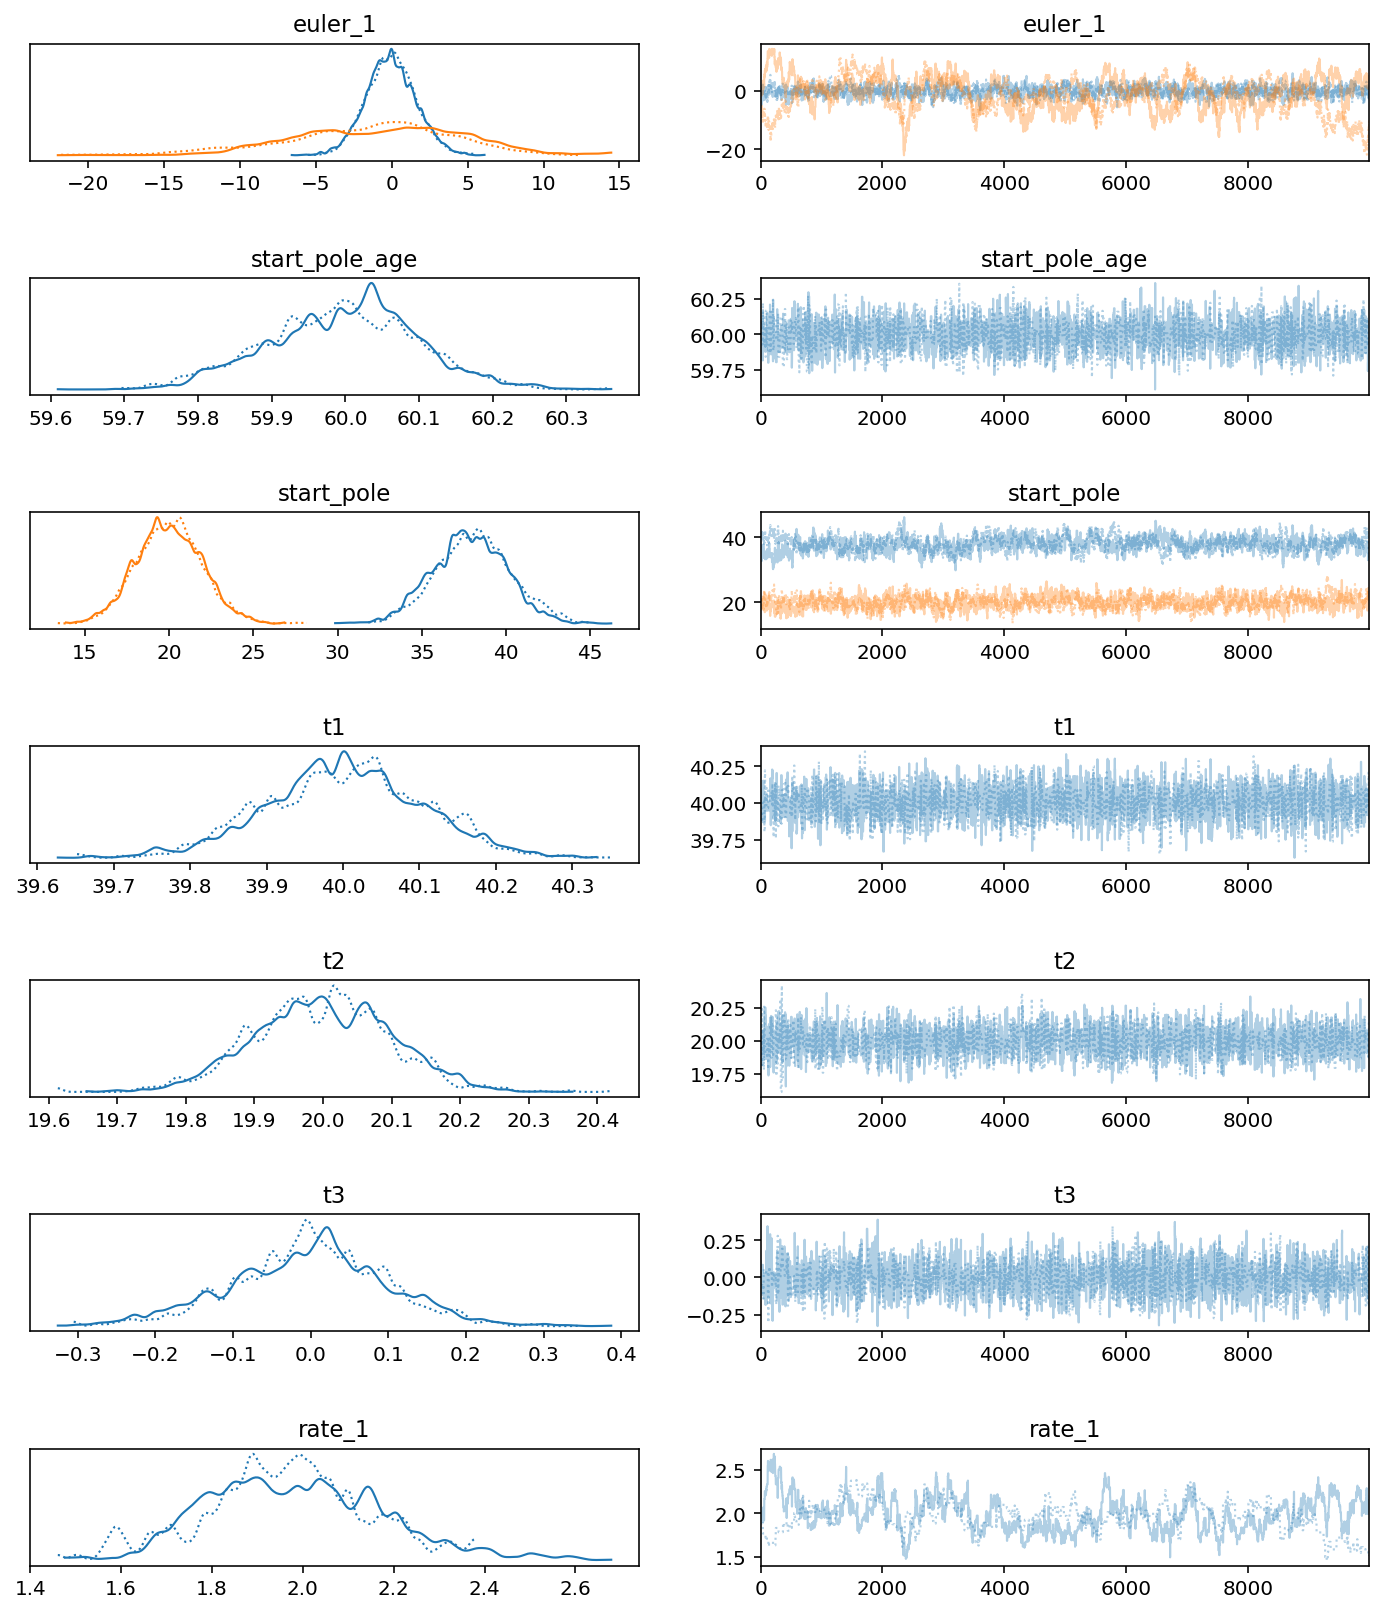

In [89]:
# plt.figure(figsize=(10, 20))
axes = pm.traceplot(trace, compact=1)
plt.subplots_adjust(hspace = 1 )
plt.savefig('code_output/1_euler_inversion_traceplot.pdf', bbox_inches='tight')

In [78]:
pm.save_trace(trace, 'code_output/1_euler_trace', overwrite=1)

'code_output/1_euler_trace'

In [54]:
def plot_trace_1e( trace, lon_lats, ages, central_lon = 30., central_lat = 30., num_points_to_plot = 200, num_paths_to_plot = 200, savefig = False, figname = '1_Euler_inversion_test.pdf'):
    def pole_position( start, euler_1, rate_1, time ):

        euler_pole_1 = EulerPole( euler_1[0], euler_1[1], rate_1)
        start_pole = PaleomagneticPole(start[0], start[1], age=time)

        start_pole.rotate( euler_pole_1, euler_pole_1.rate*time)

        lon_lat = np.array([start_pole.longitude, start_pole.latitude])

        return lon_lat
    
    euler_1_directions = trace.euler_1
    rates_1 = trace.rate_1

    start_directions = trace.start_pole

    interval = max([1,int(len(rates_1)/num_paths_to_plot)])

    ax = ipmag.make_orthographic_map(central_lon, central_lat, add_land=0, grid_lines = 1)
    
    plot_distributions(ax, euler_1_directions[:,0], euler_1_directions[:,1])

    age_list = np.linspace(ages[0], ages[-1], num_paths_to_plot)
    pathlons = np.empty_like(age_list)
    pathlats = np.empty_like(age_list)
    for start, e1, r1 in zip(start_directions[::interval], 
                        euler_1_directions[::interval], rates_1[::interval]):
        for i,a in enumerate(age_list):
            lon_lat = pole_position( start, e1, r1, a)
            pathlons[i] = lon_lat[0]
            pathlats[i] = lon_lat[1]

        ax.plot(pathlons,pathlats,color='b', transform=ccrs.PlateCarree(), alpha=0.05)
    for i in range(len(lon_lats)):
        this_pole = Pole(lon_lats[i][0], lon_lats[i][1], A95=5.)
        this_pole.plot(ax, color='C'+str(i))
    if savefig == True:
        plt.savefig(figname)
    plt.show()
    
    
def bin_trace(lon_samples, lat_samples, resolution):
    """
    Given a trace of samples in longitude and latitude, bin them
    in latitude and longitude, and normalize the bins so that
    the integral of probability density over the sphere is one.

    The resolution keyword gives the number of divisions in latitude.
    The divisions in longitude is twice that.
    """
    lats = np.linspace(-90., 90., resolution, endpoint=True)
    lons = np.linspace(-180., 180., 2 * resolution, endpoint=True)
    lon_grid, lat_grid = np.meshgrid(lons, lats)
    hist = np.zeros_like(lon_grid)

    dlon = 360. / (2. * resolution)
    dlat = 180. / resolution

    for lon, lat in zip(lon_samples, lat_samples):

        lon = np.mod(lon, 360.)
        if lon > 180.:
            lon = lon - 360.
        if lat < -90. or lat > 90.:
            # Just skip invalid latitudes if they happen to arise
            continue

        lon_index = int(np.floor((lon + 180.) / dlon))
        lat_index = int(np.floor((lat + 90.) / dlat))
        hist[lat_index, lon_index] += 1

    lat_grid += dlat / 2.
    lon_grid += dlon / 2.
    return lon_grid, lat_grid, hist


def density_distribution(lon_samples, lat_samples, resolution=30):
    count = len(lon_samples)
    lon_grid, lat_grid, hist = bin_trace(lon_samples, lat_samples, resolution)
    return lon_grid, lat_grid, hist / count


def cumulative_density_distribution(lon_samples, lat_samples, resolution=30):

    lon_grid, lat_grid, hist = bin_trace(lon_samples, lat_samples, resolution)

    # Compute the cumulative density
    hist = hist.ravel()
    i_sort = np.argsort(hist)[::-1]
    i_unsort = np.argsort(i_sort)
    hist_cumsum = hist[i_sort].cumsum()
    hist_cumsum /= hist_cumsum[-1]

    return lon_grid, lat_grid, hist_cumsum[i_unsort].reshape(lat_grid.shape)


def plot_distributions(ax, lon_samples, lat_samples, to_plot='d', resolution=30, **kwargs):

    if 'cmap' in kwargs:
        cmap = kwargs.pop('cmap')
    else:
        cmap = next(cmaps)

    artists = []

    if 'd' in to_plot:
        lon_grid, lat_grid, density = density_distribution(
            lon_samples, lat_samples, resolution)
        density = ma.masked_where(density <= 0.05*density.max(), density)
        a = ax.pcolormesh(lon_grid, lat_grid, density, cmap=cmap,
                          transform=ccrs.PlateCarree(), **kwargs)
        artists.append(a)

    if 'e' in to_plot:
        lon_grid, lat_grid, cumulative_density = cumulative_density_distribution(
            lon_samples, lat_samples, resolution)
        a = ax.contour(lon_grid, lat_grid, cumulative_density, levels=[
                       0.683, 0.955], cmap=cmap, transform=ccrs.PlateCarree())
        artists.append(a)

    if 's' in to_plot:
        a = ax.scatter(lon_samples, lat_samples, color=cmap(
            [0., 0.5, 1.])[-1], alpha=0.1, transform=ccrs.PlateCarree(), edgecolors=None, **kwargs)
        artists.append(a)

    return artists

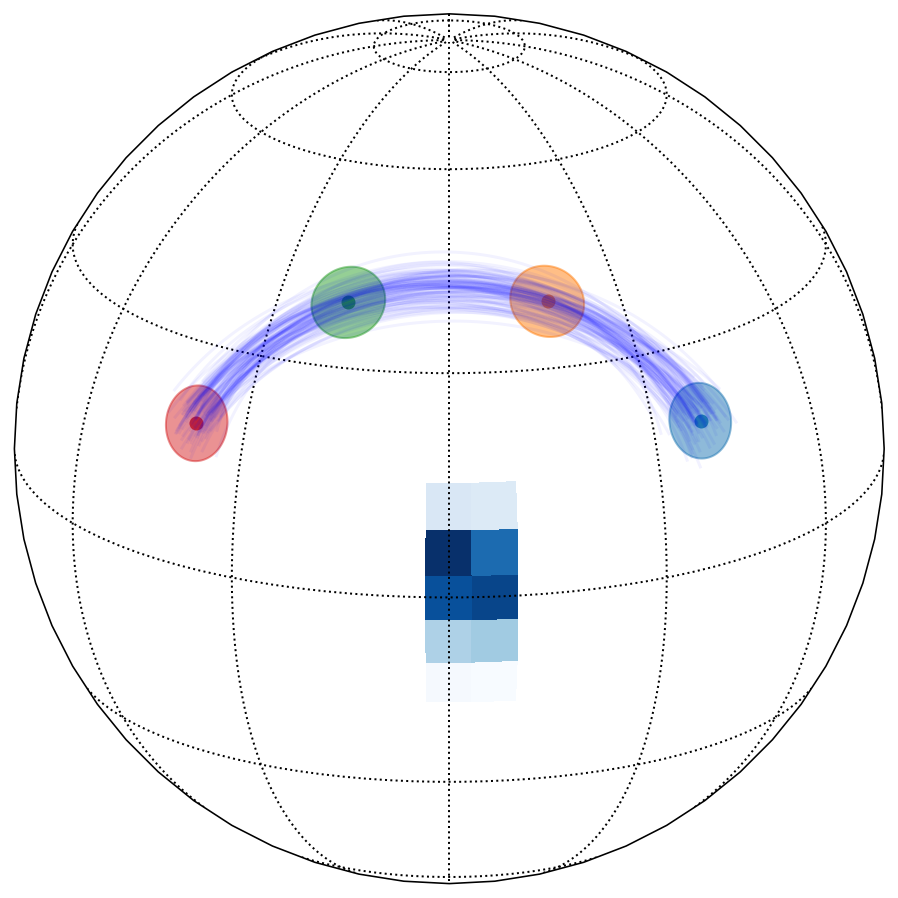

In [90]:
plot_trace_1e(trace, one_euler_data[['pole_lon', 'pole_lat']].to_numpy(), ages, 0, 20, 100, 100, savefig = 0)

Got error No model on context stack. trying to find log_likelihood in translation.


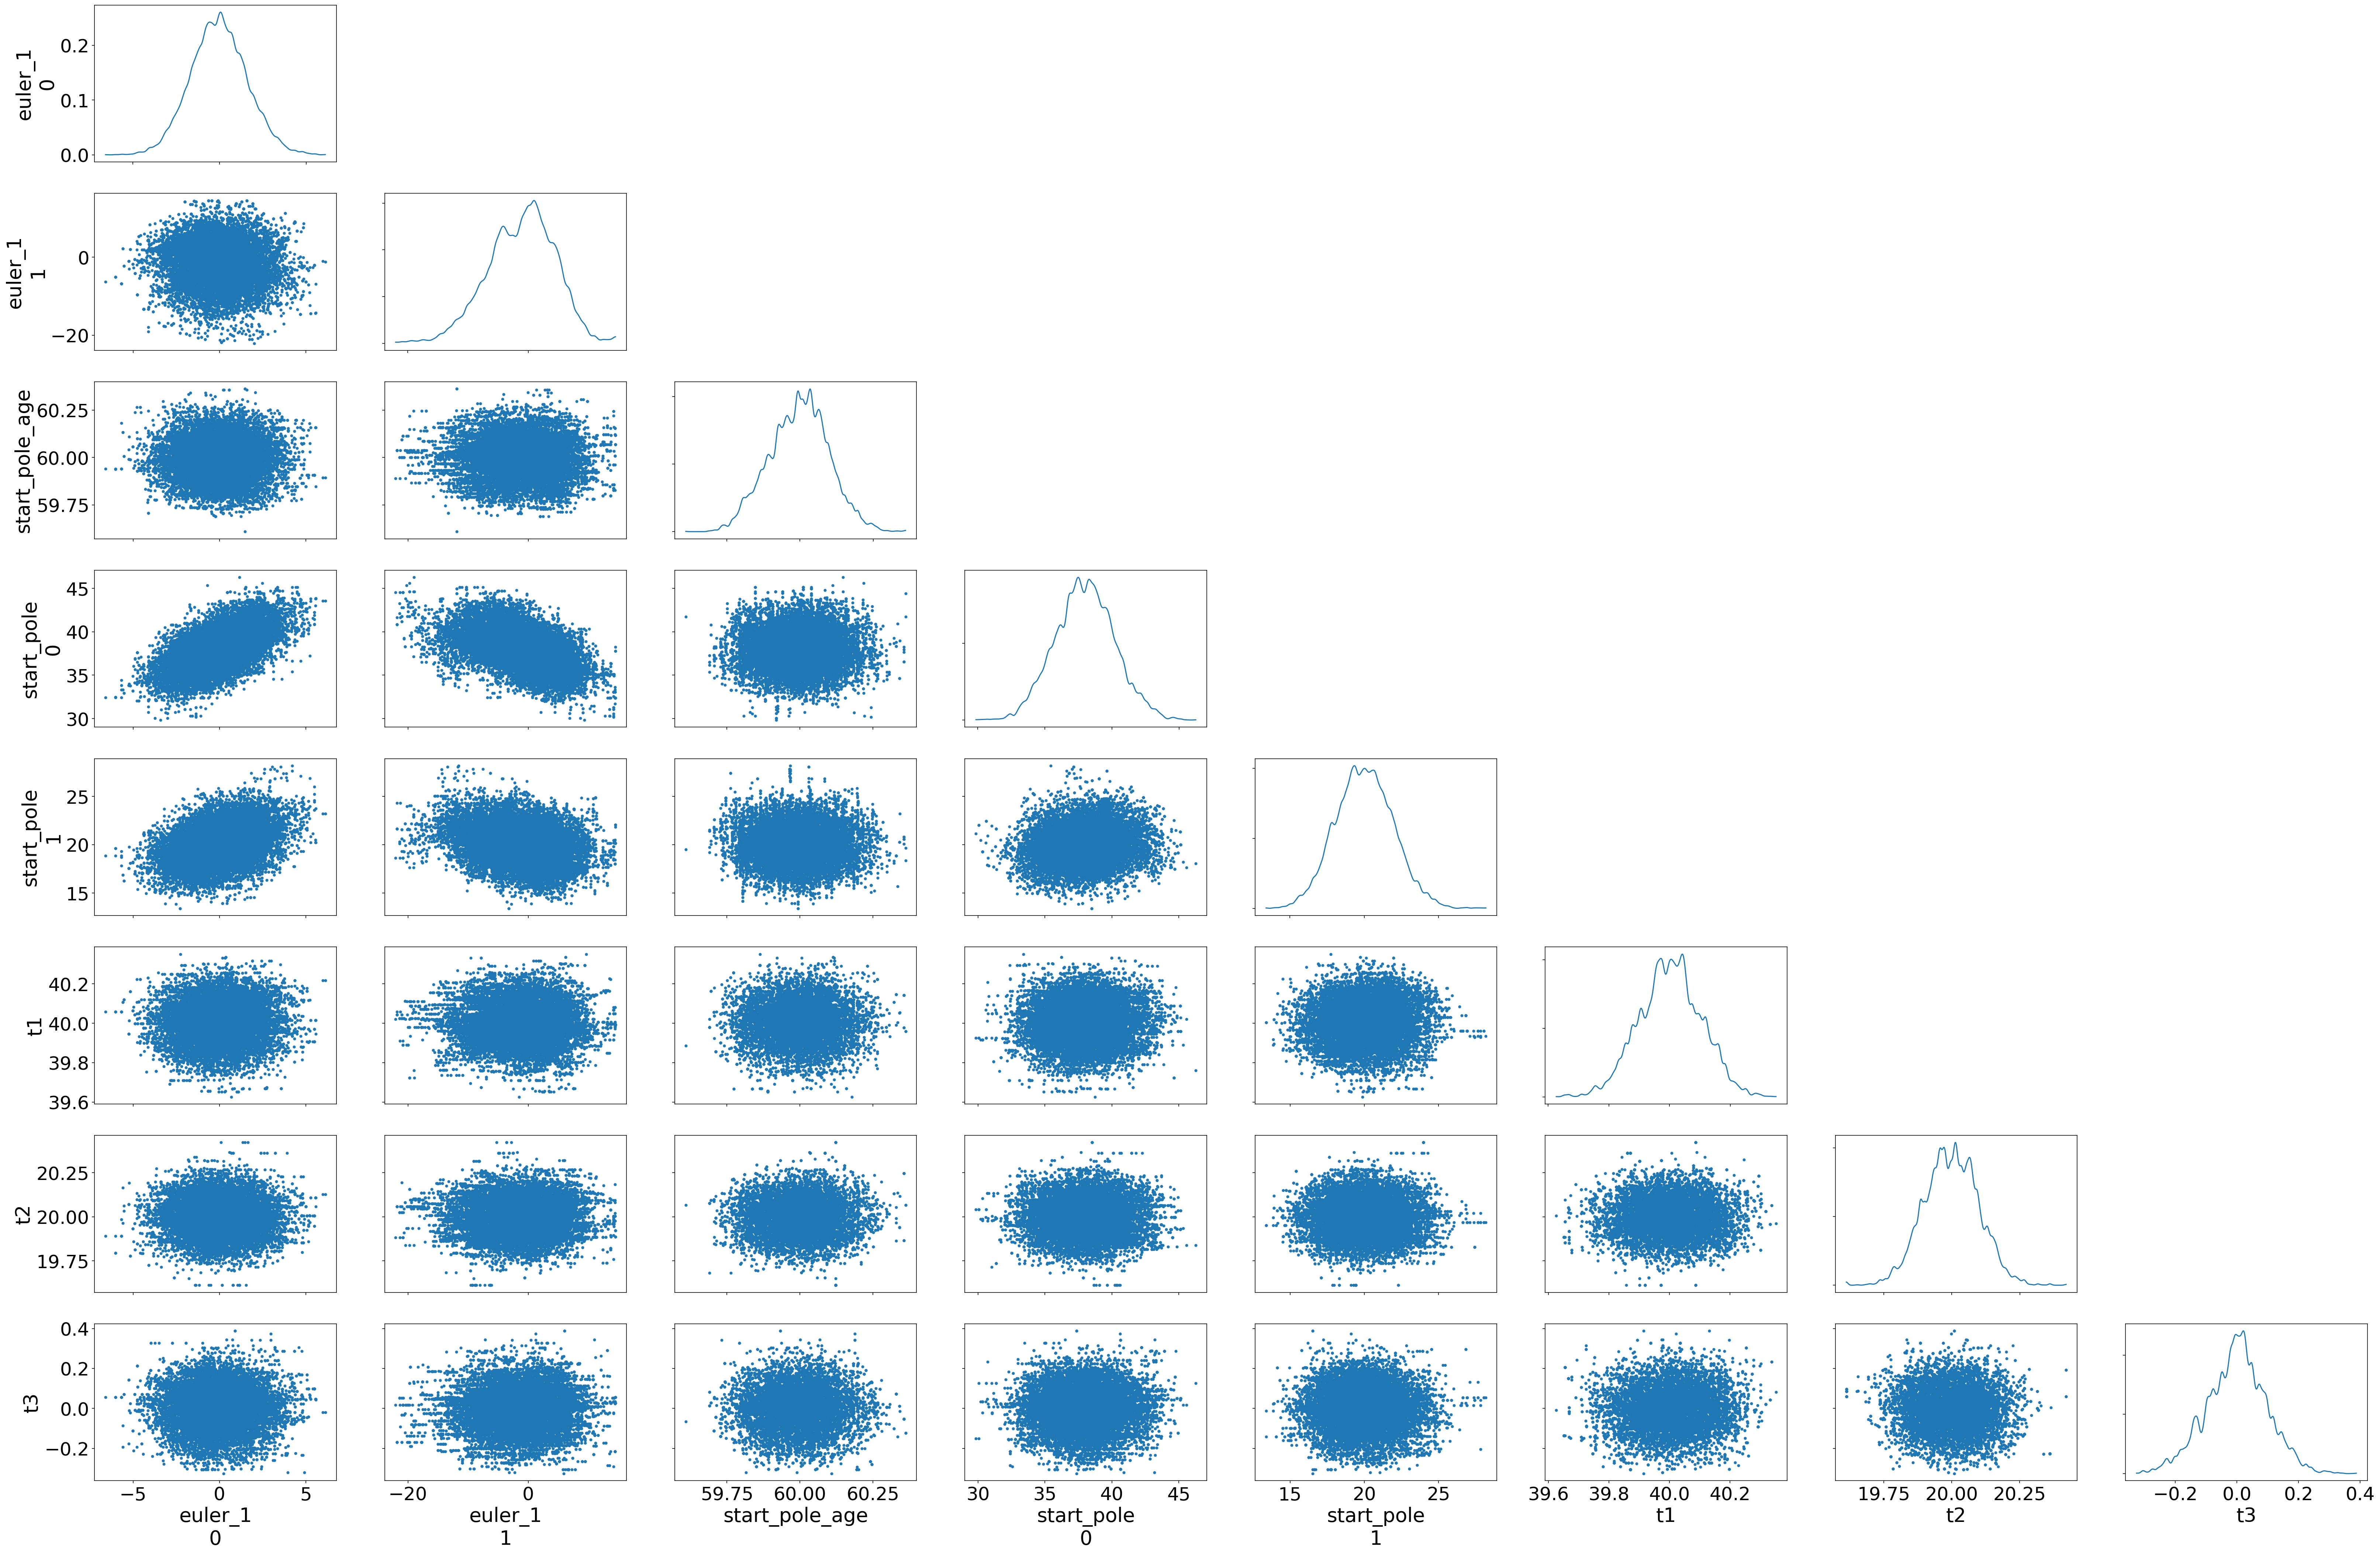

In [91]:
import arviz as az
az.plot_pair(
    trace,
#     var_names=["atts"],
    kind="scatter",
    divergences=True,
    textsize=25,
    marginals=True,
),
figsize = (10, 10)

### one euler inversion without age uncertainties

In [7]:
# Generate a synthetic data set
ages =[0.,10.,20.,30.,40]
lon_lats = [[300., -20.], [340.,0.], [0.,30.], [20., 0.], [60.,-20.]]
# lon_lats = [[300., 45.], [330., 45.], [0., 45.], [30., 45.], [60., 45.]]

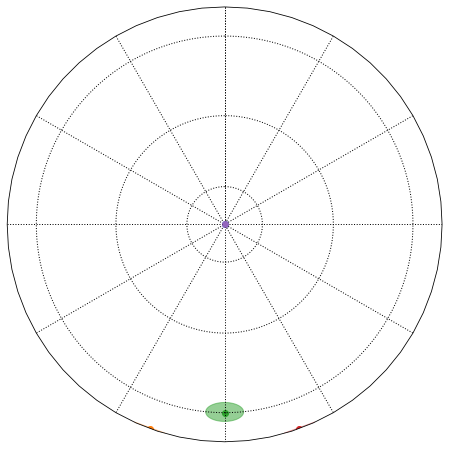

In [8]:
ax = ipmag.make_orthographic_map(0., 90., add_land=0, grid_lines = 1)
for i in range(len(lon_lats)):
    this_pole = Pole(lon_lats[i][0], lon_lats[i][1], A95=5.)
    this_pole.plot(ax, color = 'C'+str(i))
#     ipmag.plot_pole(ax, lon_lat[0], lon_lat[1], 5, color = 'dodgerblue')
# plt.savefig('small_circle_poles.pdf', bbox_inches = 'tight')
plt.show() 

### one euler inversion with age uncertainties

In [17]:
# Generate a synthetic data set
ages =[0.,10.,20.,30.,40]
sigma_ages = np.array([0.1, 0.1, 0.1, 0.1, 0.1])
age_taus = 1./(sigma_ages*sigma_ages)
lon_lats = [[300., 45.], [330., 45.], [0., 45.], [30., 45.], [60., 45.]]

ValueError: setting an array element with a sequence.

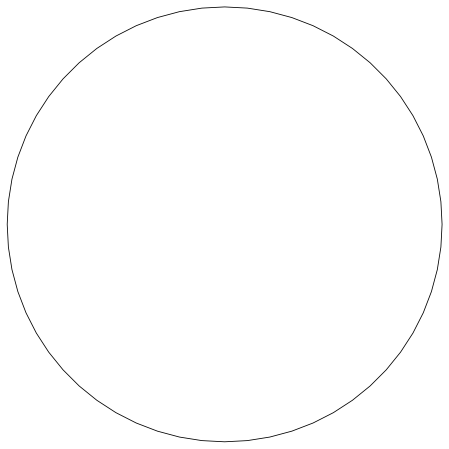

In [18]:
ax = ipmag.make_orthographic_map(0., 90., add_land=0, grid_lines = 0)
for i in range(len(lon_lats)):
    this_pole = Pole(lon_lats[i][0], lon_lats[i][1], A95=5.)
    this_pole.plot(ax, color='C'+str(i))
#     ipmag.plot_pole(ax, lon_lat[0], lon_lat[1], 5, color = 'dodgerblue')
# plt.savefig('small_circle_poles.pdf', bbox_inches = 'tight')
plt.show() 

In [57]:
theano.config.floatX = 'float64'

with pm.Model() as model:

    euler_1 = VMF('euler_1', lon_lat = [1.,0.,], k = 1., testval = np.array([1., 0.]), shape = 2)
    rate_1 = pm.Exponential('rate_1', 2.5) 
    
    start = VMF('start', lon_lat=lon_lats[0], k = kappa_from_two_sigma(10.), testval = np.array([1., 0.]), shape = 2)


    for i in range(len(ages)):
        time = pm.Normal('t'+str(i), mu=ages[i], tau=sigma_ages[i])
#         lon_lat = pm.DensityDist('ll'+str(i), lambda placehoder = 0., st=start, e1=euler_1, r1=rate_1, e2=euler_2, r2=rate_2, sw=switchpoint, t=time : pole_position(st, e1, r1, e2, r2, sw, t))
        lon_lat = pole_position_1e(start, euler_1, rate_1, time )

        observed_pole = VMF('p'+str(i), lon_lat, k = kappa_from_two_sigma(10.), observed=lon_lats[i])
    trace = pm.sample(2000, step = pm.Metropolis(), compute_convergence_checks=False, cores=1)

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [t4]
>Metropolis: [t3]
>Metropolis: [t2]
>Metropolis: [t1]
>Metropolis: [t0]
>Metropolis: [start]
>Metropolis: [rate_1]
>Metropolis: [euler_1]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 152 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


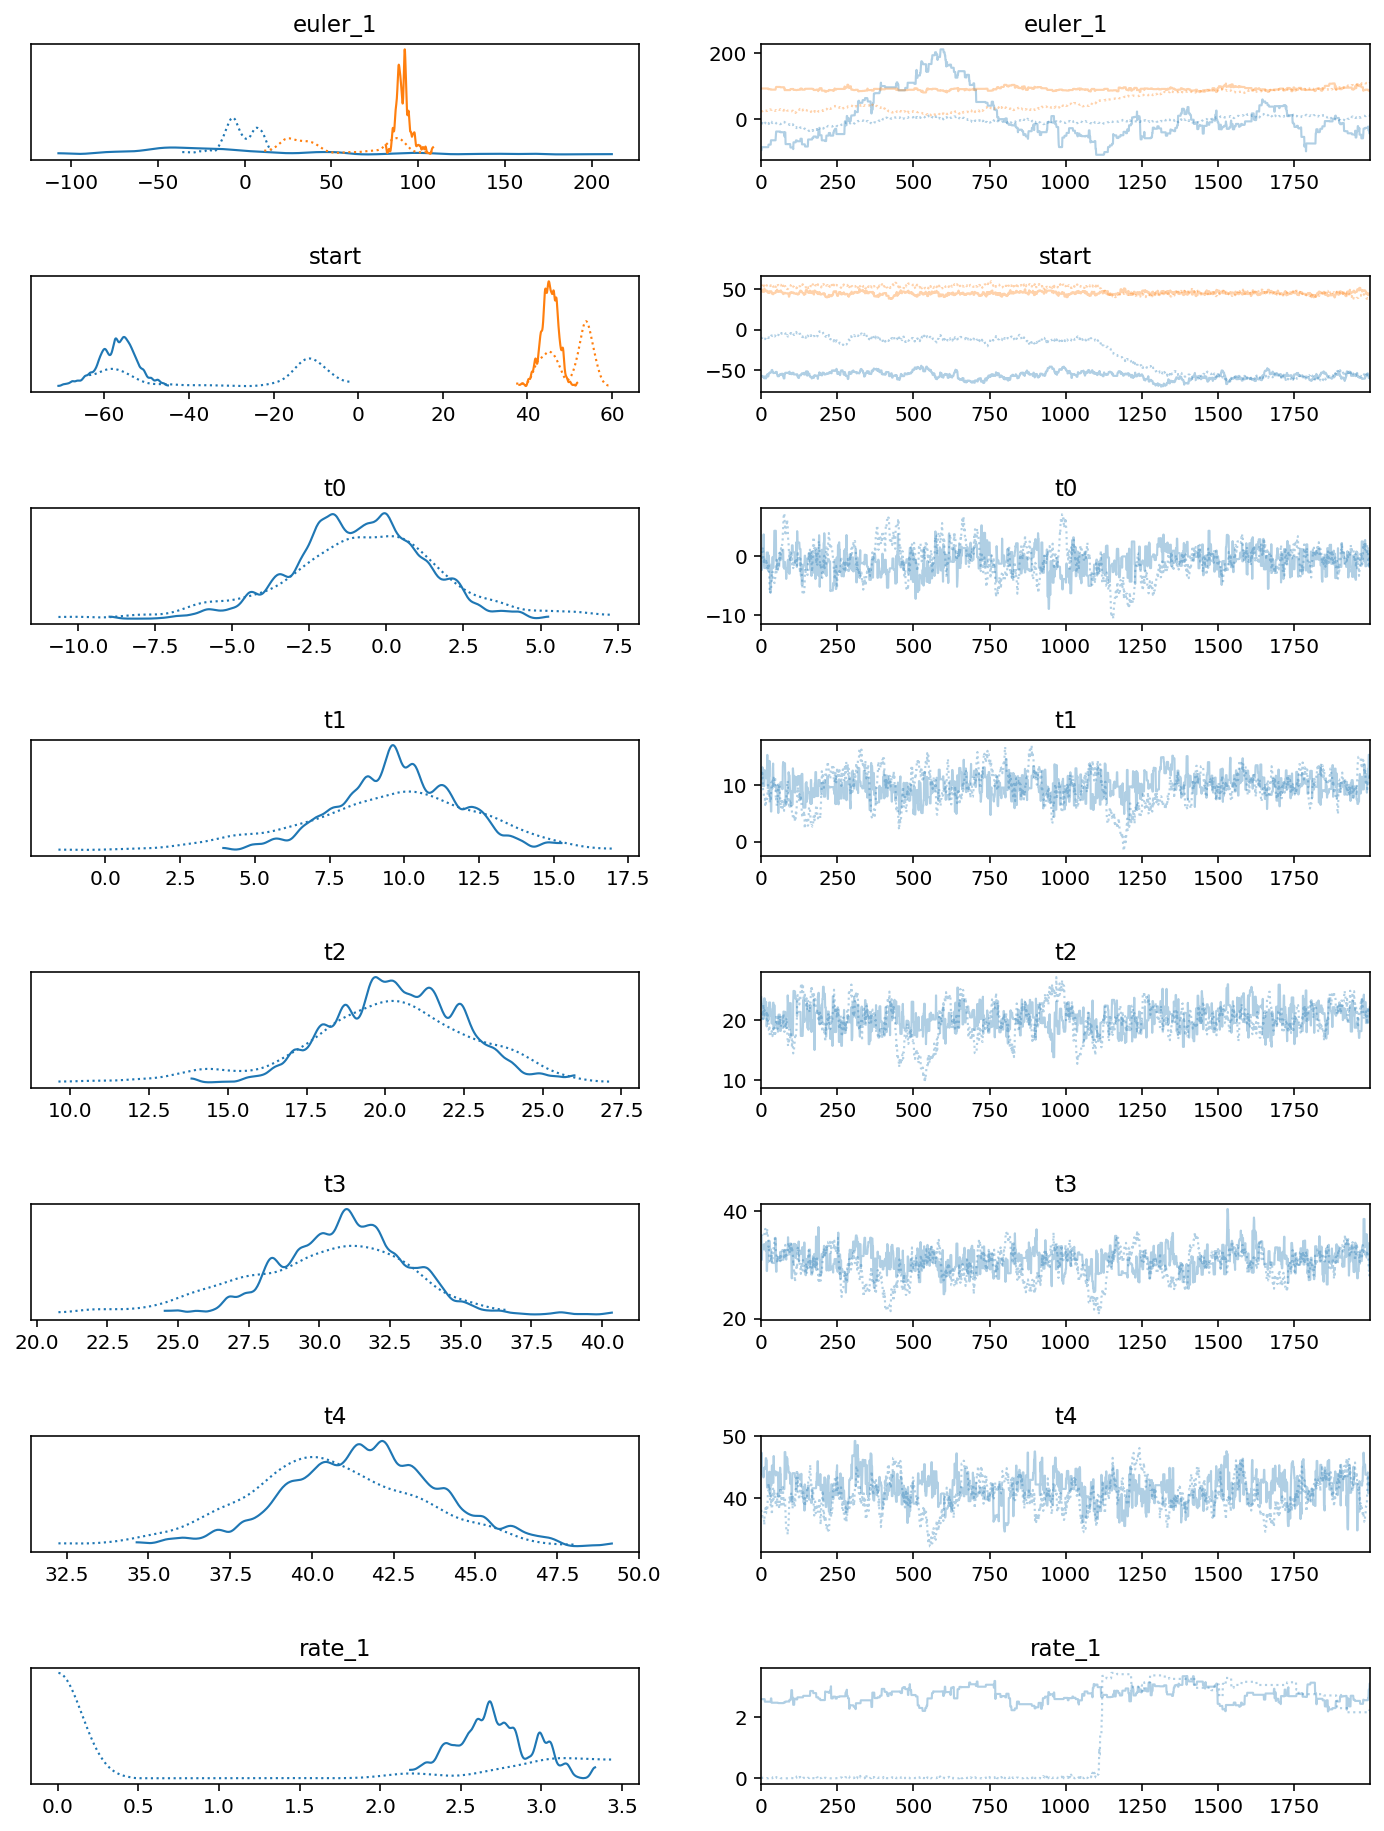

In [58]:
# plt.figure(figsize=(10, 20))
axes = pm.traceplot(trace, compact=1)
plt.subplots_adjust(hspace = 1 )
plt.savefig('1_euler_inversion_traceplot.pdf', bbox_inches='tight')

## plot trace function

In [26]:
plot_trace_1e(trace, lon_lats, ages, 0, 65, 100, 100, savefig = 0)

NameError: name 'lon_lats' is not defined

### try 2 euler inversion

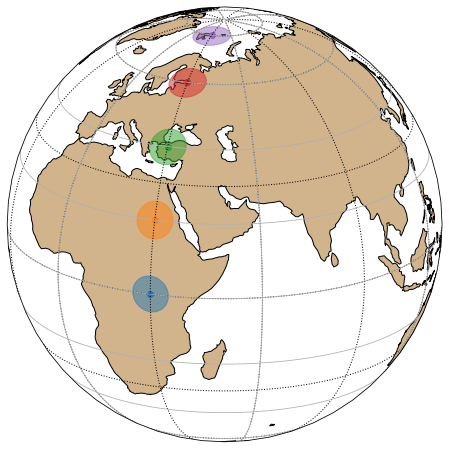

In [ ]:

pole1 = Pole( 30., 0., A95=5.)
pole2 = Pole( 30., 20., A95=5.)
pole3 = Pole( 30., 40., A95=5.)
pole4 = Pole( 30., 60., A95=5.)
pole5 = Pole( 30., 80., A95=5.)

ax = ipmag.make_orthographic_map(50, 20)
ax.set_global()
ax.gridlines()
pole1.plot(ax, color='C0')
pole2.plot(ax, color='C1')
pole3.plot(ax, color='C2')
pole4.plot(ax, color='C3')
pole5.plot(ax, color='C4')

# pole3.rotate(Pole(30, 0), 10)
# print(pole3._pole)
# print(pole1.longitude)
# pole3.plot(ax, color='orange')
# plt.savefig('Figures/great_circle_poles.pdf', bbox_inches = 'tight')
plt.show()

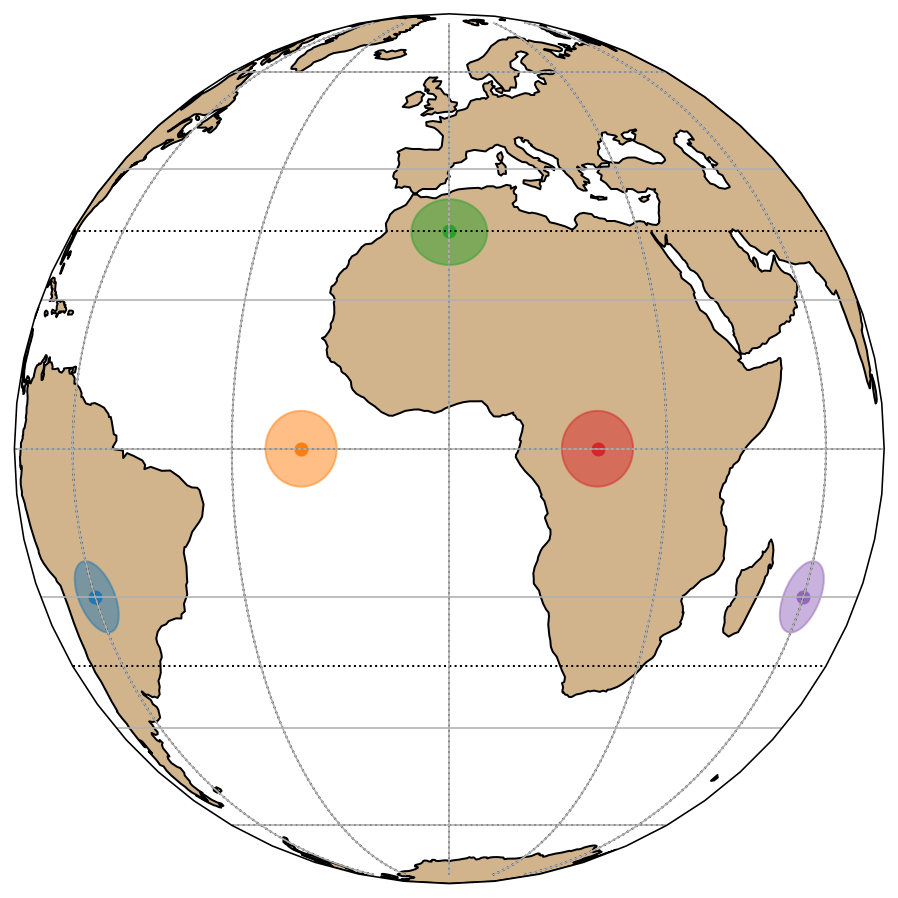

In [12]:
pole1 = Pole( 300., -20., A95=5.)
pole2 = Pole( 340., 0., A95=5.)
pole3 = Pole( 0., 30., A95=5.)
pole4 = Pole( 20., 0., A95=5.)
pole5 = Pole( 60., -20., A95=5.)

ax = ipmag.make_orthographic_map(000, 0)
ax.set_global()
ax.gridlines()
pole1.plot(ax, color='C0')
pole2.plot(ax, color='C1')
pole3.plot(ax, color='C2')
pole4.plot(ax, color='C3')
pole5.plot(ax, color='C4')

# pole3.rotate(Pole(30, 0), 10)
# print(pole3._pole)
# print(pole1.longitude)
# pole3.plot(ax, color='orange')
# plt.savefig('Figures/two_euler_poles.pdf', bbox_inches = 'tight')
plt.show()

In [95]:
ages =[0.,10.,20.,30.,40]
sigma_ages = np.array([2., 2., 2., 2., 2.])
age_taus = 1./sigma_ages*sigma_ages
lon_lats = [ [300., -20.], [340.,0.], [0.,30.], [20., 0.], [60.,-20.]]

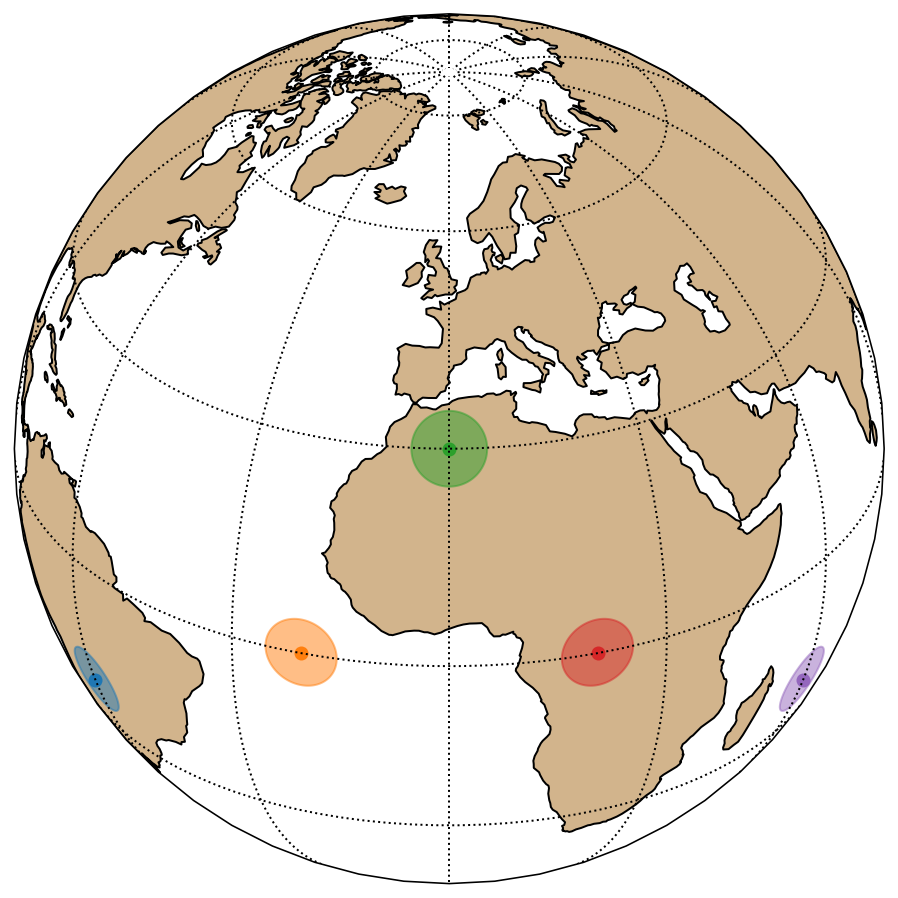

In [100]:
ax = ipmag.make_orthographic_map(0., 30.)
for i in range(len(lon_lats)):
    this_pole = Pole(lon_lats[i][0], lon_lats[i][1], A95=5.)
    this_pole.plot(ax, color='C'+str(i))
#     ipmag.plot_pole(ax, lon_lat[0], lon_lat[1], 5, color = 'dodgerblue')
plt.savefig('2_small_circle_poles.pdf', bbox_inches = 'tight')
plt.show() 

In [84]:
with pm.Model() as model:

    euler_1 = VMF('euler_1', lon_lat = [1.,0.,], k = 1., testval = np.array([1., 0.]), shape = 2)
    rate_1 = pm.Exponential('rate_1', 1.) 
    euler_2 = VMF('euler_2', lon_lat = [1.,0.,], k = 1., testval = np.array([1., 0.]), shape = 2)
    rate_2 = pm.Exponential('rate_2', 1.) 
    
    start = VMF('start', lon_lat=lon_lats[0], k = kappa_from_two_sigma(10.), testval = np.array([1., 0.]), shape = 2)
    
    switchpoint = pm.Uniform('switchpoint', ages[0], ages[-1])


    for i in range(len(ages)):
        time = pm.Normal('t'+str(i), mu=ages[i], tau=age_taus[i])
#         lon_lat = pm.DensityDist('ll'+str(i), lambda placehoder = 0., st=start, e1=euler_1, r1=rate_1, e2=euler_2, r2=rate_2, sw=switchpoint, t=time : pole_position(st, e1, r1, e2, r2, sw, t))
        lon_lat = pole_position_2e(start, euler_1, rate_1, euler_2, rate_2, switchpoint, time )

        observed_pole = VMF('p'+str(i), lon_lat, k = kappa_from_two_sigma(5.), observed=lon_lats[i])
    trace = pm.sample(2000, step = pm.Metropolis(), compute_convergence_checks=False, cores=1)

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [t4]
>Metropolis: [t3]
>Metropolis: [t2]
>Metropolis: [t1]
>Metropolis: [t0]
>Metropolis: [switchpoint]
>Metropolis: [start]
>Metropolis: [rate_2]
>Metropolis: [euler_2]
>Metropolis: [rate_1]
>Metropolis: [euler_1]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 351 seconds.


In [91]:
trace_dataframe = pm.trace_to_dataframe(trace)
trace_dataframe.head()

euler_1__0  euler_1__1  euler_2__0  euler_2__1   start__0   start__1  \
0 -133.453890   53.074083   64.264533   31.555727 -55.506022 -18.287971   
1 -138.851038   52.345286   64.264533   31.555727 -55.237007 -17.658739   
2 -138.851038   52.345286   64.264533   31.555727 -55.237007 -17.658739   
3 -134.177076   53.418466   70.541426   34.349526 -55.237007 -17.658739   
4 -134.177076   53.418466   70.541426   34.349526 -55.725371 -19.053414   

         t0         t1         t2         t3         t4    rate_1    rate_2  \
0 -1.061249  11.470320  21.417097  29.785445  41.446212  3.275339  5.286259   
1 -1.612135  11.470320  21.878069  29.785445  41.446212  3.275339  5.286259   
2 -1.833124  10.444913  19.617295  30.262893  41.223507  3.275339  5.286259   
3 -1.896285  10.444913  19.668911  30.385393  41.192001  3.275339  4.795216   
4 -0.374570  10.444913  19.668911  30.773015  41.192001  3.275339  4.565207   

   switchpoint  
0     23.63052  
1     23.63052  
2     24.00338  
3     24.00338  
4     24.00338

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


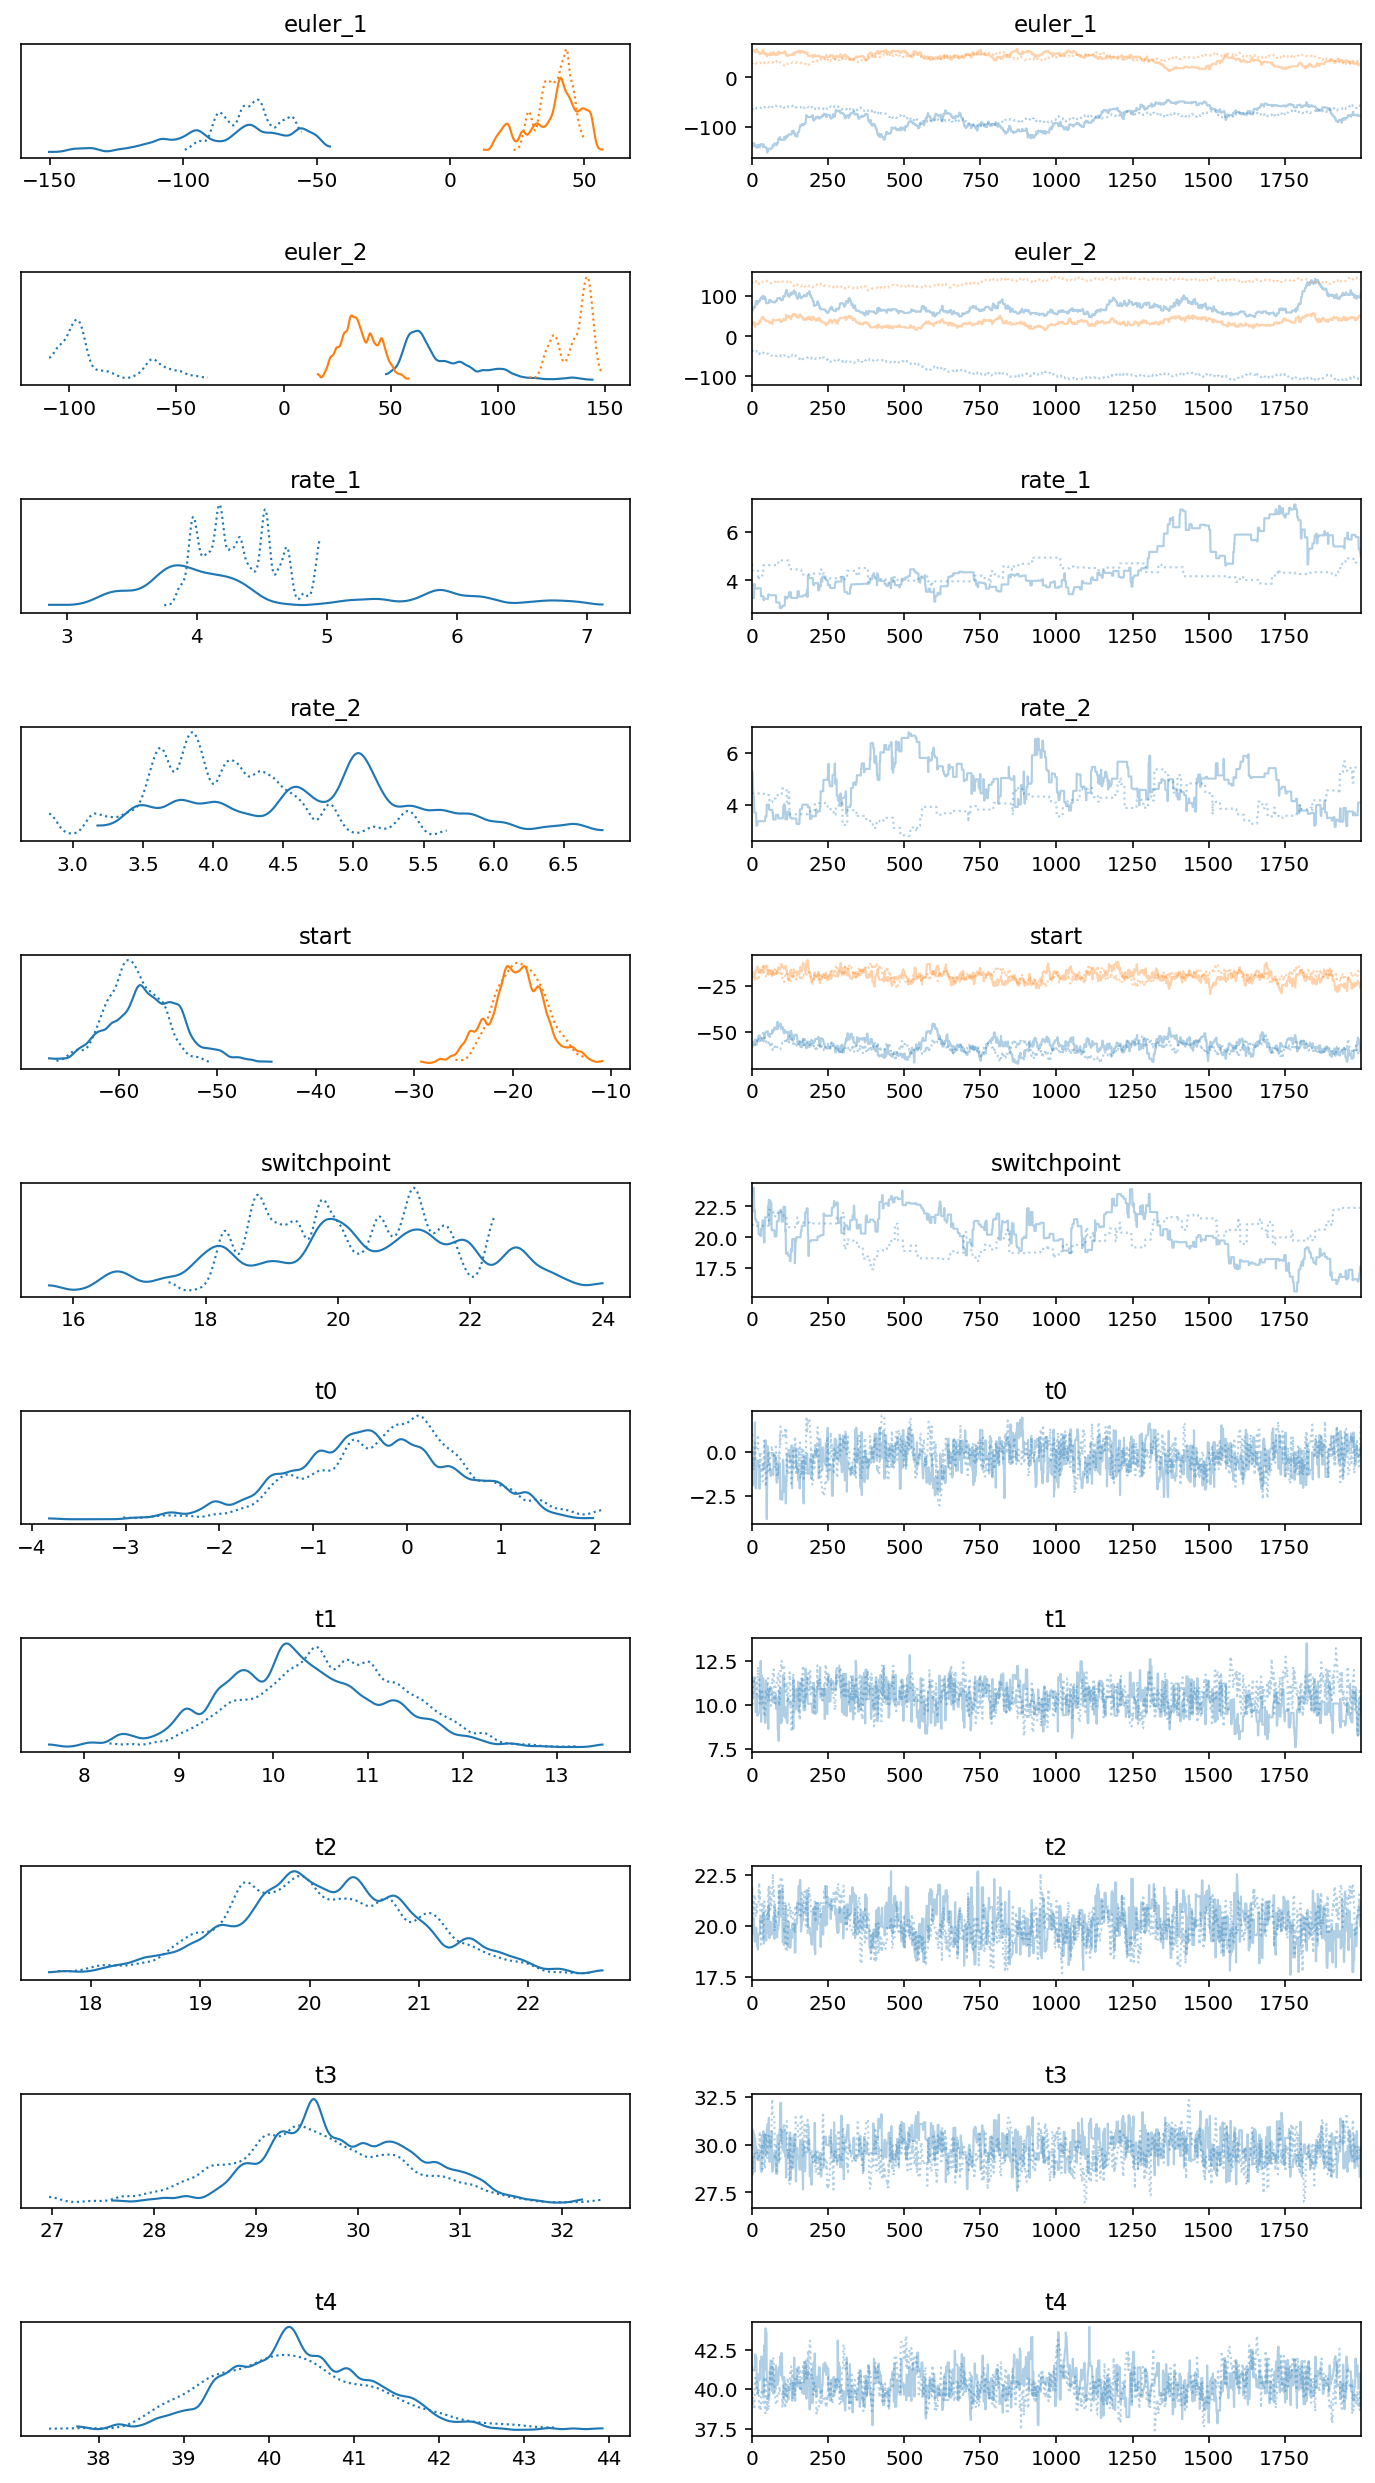

In [94]:
pm.traceplot(trace, ['euler_1', 'euler_2', 'rate_1', 'rate_2', 'start', 'switchpoint', 't0', 't1', 't2', 't3', 't4'])
plt.subplots_adjust(hspace = 1 )
plt.savefig('2_euler_inversion_traceplot.pdf', bbox_inches='tight')
plt.show()

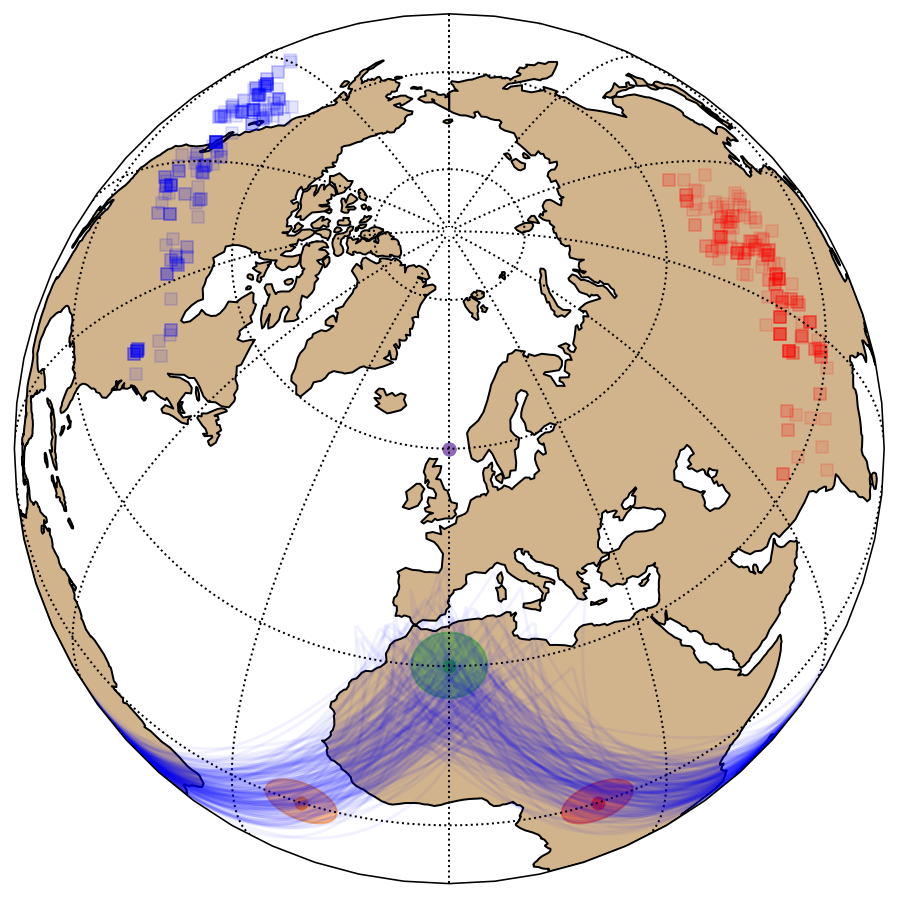

In [98]:
plot_trace(trace, lon_lats, ages, 0, 60, 200, 200, savefig = True, figname='2_Euler_inversion_test.pdf')

### APWP class

In [71]:
def pole_position(start, start_age, this_age, euler_list, rate_list, changepoint_list, tpw_pole_angle=0., tpw_rate=0.):
#         if len(args) != max( (n_euler_poles * 3 - 1), 0):
#             raise Exception("Unexpected number of euler poles/changepoints: expected %i, got %i"%(n_euler_poles*3-1, len(args)))
        n_euler_poles = len(euler_list)
#         if len(changepoint_list)==0:
#             changepoint_list.append(0.0)
        changepoint_list = np.sort(changepoint_list)[::-1]
#         print(changepoint_list)
        # make a starting pole
        start_pole = PaleomagneticPole(start[0], start[1], age=this_age)

        # make a TPW pole
        test_1 = np.array([0.,0.,1.])
        test_2 = np.array([1.,0.,0.])

        # determine which side the tpw pole is on the globe
#         if np.dot(start_pole_cart, test_1) > np.dot(start_pole_cart, test_2):
        if T.gt(np.dot(start_pole._pole, test_1), np.dot(start_pole._pole, test_2)):
            tpw_pole = np.cross(start_pole._pole, test_2) # tpw pole in cartesian coordinates
        else:
            tpw_pole = np.cross(start_pole._pole, test_1) # tpw pole in cartesian coordinates

    #         print(start_pole_cart, tpw_pole, tpw_pole_angle)
    #         tpw = rotate(start_pole_cart, tpw_pole, tpw_pole_angle)      # amount of tpw in cartesian coordinates

        if n_euler_poles == 0:
            start_pole = start_pole.rotate(tpw_pole, tpw_rate * (start_age-this_age))
        else:
            for e, r, c in zip(euler_list, rate_list, changepoint_list):
                # add tpw contribution
#                 this_euler = spherical_to_cartesian(e[0], e[1])
#                 this_euler = spherical_to_cartesian(e[0], e[1]) + tpw # cartesian coordinates current euler pole plus tpw
                if this_age < c:
                    angle = r * (start_age - c)
                    start_pole = start_pole.rotate(e, angle)
                    start_pole = c
                else:
                    angle = r * (start_age - this_age)
                    start_pole = start_pole.rotate(e, angle)
                    break

        lon, lat = start_pole.longitude, start_pole.latitude
        return T.stacklists([lon, lat])

In [74]:
theano.config.floatX = 'float64'
def create_model(name = None, 
                 paleomagnetic_pole_list = None, 
                 A95_list = None,
                 age_list = None, 
                 age_uncertainty_list = None,
                 age_uncertainty_type_list = None,
                 n_euler_poles=0, 
                 include_tpw = False, 
                 site_lon_lat=[1., 0.], 
                 k=1., 
                 kw = -1., 
                 euler_rate=1., 
                 tpw_pole_angle = None,
                 tpw_rate_scale = None, 
                 sample_size = 2000):
    
    assert name != None, "must have a model name"
    assert paleomagnetic_pole_list != None, "must have a paleomagnetic pole list"
    assert A95_list != None, "must have a A95 list"
    assert age_list != None, "must have an age list"
    assert age_uncertainty_list != None, "must have an age uncertainty list"
    assert age_uncertainty_type_list != None, "must have an age uncertainty type list"
    assert n_euler_poles >= 0 , "must have a nonnegative euler pole number"
    
    assert euler_rate > 0.0, "rate_scale must be a positive number."
    assert tpw_pole_angle == None or tpw_rate_scale > 0.0, "true polar wander angle must be nonnegative"
    assert tpw_rate_scale == None or tpw_rate_scale > 0.0, "true polar wander rate must be nonnegative"
    assert kw <= 0.0, "nonnegative Watson concentration parameters are not supported"
    
    
    
    start_age = max(age_list)
    start_pole = paleomagnetic_pole_list[np.argmax(age_list)]
    start_A95 = A95_list[np.argmax(age_list)]
    
    if tpw_rate_scale is None:
        include_tpw = False
    else:
        include_tpw = True
        
    with pm.Model() as APWP_model:   
        start = VMF('start', 
                    lon_lat = start_pole, 
                    k = kappa_from_two_sigma(start_A95), 
                    testval = np.array([1., 0.]), shape = 2)
        
        euler_list = []
        rate_list = []
        changepoint_list = []
        
        # set up true polar wander variable if necessary
        if include_tpw:
            tpw_pole_angle = pm.Uniform('tpw_pole_angle', 0., 360., testval=0., observed=False)
            tpw_rate = pm.Exponential('tpw_rate', tpw_rate_scale)

        # Make Euler pole direction random variables
        for i in range(n_euler_poles):
            euler = VMF('euler_' + str(i+1), lon_lat=site_lon_lat, k=k, testval=np.array([1.,0.]), shape = 2)
            euler_list.append(euler)
            
        # Make Euler pole rate random variables
        for i in range(n_euler_poles):
            rate = pm.Exponential('rate_' + str(i+1), euler_rate)
            rate_list.append(rate)
            
        # Make changepoint random variables
        for i in range(n_euler_poles - 1):
            changepoint = pm.Uniform('changepoint_' + str(i+1),lower = min(age_list), upper = max(age_list))
            changepoint_list.append(changepoint)
            
        for i, (this_pole, this_A95, this_age, this_age_uncertainty, this_uncertainty_type) in enumerate(
            zip(paleomagnetic_pole_list, A95_list, age_list, age_uncertainty_list, age_uncertainty_type_list)):
                

            if this_uncertainty_type == 'gaussian':
                pole_age = pm.Normal('a_' + str(i), mu=this_age, sd = this_age_uncertainty/2)
            elif this_uncertainty_type == 'uniform':
                pole_age = pm.Uniform('a_' + str(i), lower=this_age_uncertainty[0], upper=this_age_uncertainty[1])

            if include_tpw:
                
                lon_lat = pole_position(start, start_age, pole_age, euler_list, rate_list, changepoint_list, tpw_pole_angle, tpw_rate)
            else:
                lon_lat = pole_position(start, start_age, pole_age, euler_list, rate_list, changepoint_list)
            
#             print(lon_lat)
            observed_pole = VMF('p'+str(i), lon_lat, k = kappa_from_two_sigma(this_A95), observed=this_pole)
            
        trace = pm.sample(sample_size, step = pm.Metropolis(), compute_convergence_checks=False)
        
    return trace


In [75]:
test_pmag_pole_list = [ [300., -20.], [340.,0.], [0.,30.], [20., 0.], [60.,-20.]]
# test_pmag_pole_list = [[300., 30.], [330., 30.], [0., 30.], [30., 30.], [60., 30.]]
test_A95_list = [10., 10., 10., 10., 10.]
test_age_list =[40.,30.,20.,10., 0.]
test_age_uncertainty_list = [2., 2., 2., 2., 2.]
test_age_uncertainty_type = ['gaussian', 'gaussian', 'gaussian', 'gaussian', 'gaussian']


test_trace = create_model(name = 'test', 
                 paleomagnetic_pole_list = test_pmag_pole_list, 
                 A95_list = test_A95_list,
                 age_list = test_age_list, 
                 age_uncertainty_list = test_age_uncertainty_list,
                 age_uncertainty_type_list = test_age_uncertainty_type,
                 n_euler_poles=2, 
                 include_tpw = False, 
                 site_lon_lat=[1., 0.], 
                 k=1., 
                 kw = -1., 
                 euler_rate=1., 
                 tpw_pole_angle = None,
                 tpw_rate_scale = None, 
                 sample_size = 1000)


TypeError: Variables do not support boolean operations.

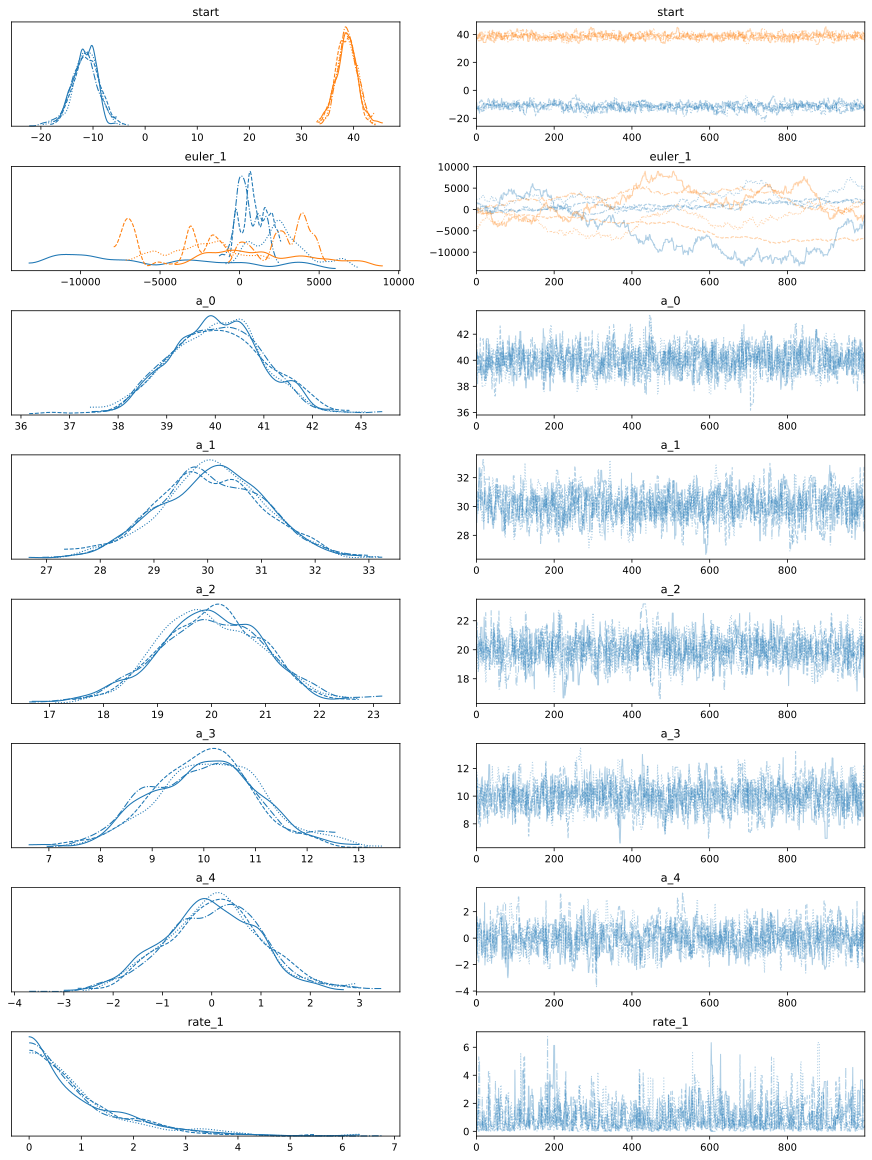

In [40]:
pm.traceplot(test_trace);

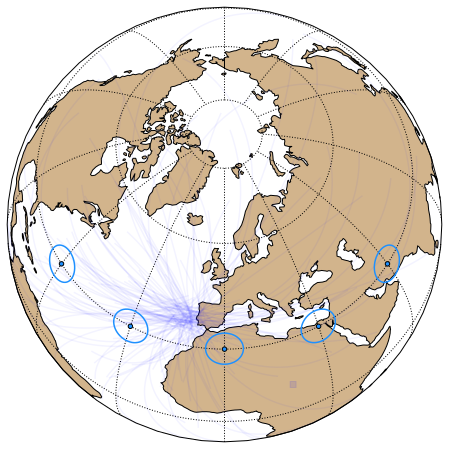

In [19]:
plot_trace_1e(test_trace, test_pmag_pole_list, test_age_list, 0, 65, 200, 200, savefig = False)

In [ ]:
test_pmag_pole_list = [ [300., -20.], [340.,0.], [0.,30.], [20., 0.], [60.,-20.]]
test_A95_list = [10., 10., 10., 10., 10.]
test_age_list =[0.,10.,20.,30.,40.]
test_age_uncertainty_list = [2., 2., 2., 2., 2.]
test_age_uncertainty_type = ['gaussian', 'gaussian', 'gaussian', 'gaussian', 'gaussian']


test_trace_2e = create_model(name = 'test', 
                 paleomagnetic_pole_list = test_pmag_pole_list, 
                 A95_list = test_A95_list,
                 age_list = test_age_list, 
                 age_uncertainty_list = test_age_uncertainty_list,
                 age_uncertainty_type_list = test_age_uncertainty_type,
                 n_euler_poles=2, 
                 include_tpw = False, 
                 site_lon_lat=[1., 0.], 
                 k=1., 
                 kw = -1., 
                 euler_rate=1., 
                 tpw_pole_angle = None,
                 tpw_rate_scale = None, 
                 sample_size = 2000)

In [ ]:
pm.traceplot(test_trace_2e);

In [ ]:
plot_trace(test_trace_2e, 0, 65, 200, 200, savefig = False)

In [31]:
def cartesian_to_spherical(vecs):
    v = np.reshape(vecs, (3, -1))
    norm = np.sqrt(v[0, :] * v[0, :] + v[1, :] * v[1, :] + v[2, :] * v[2, :])
    latitude = 90. - np.arccos(v[2, :] / norm) * r2d
    longitude = np.arctan(v[1, :]/v[0, :]) * r2d
    v1 = v[1, :]
    v0 = v[0, :]
    for i in range(len(longitude)):
        if T.lt(v1[i], 0) and T.lt(v0[i], 0):
            longitude[i] = longitude[i] + 180
        elif T.gt(v1[i], 0) and T.lt(v0[i], 0):
            longitude[i] = longitude[i] + 180

    return longitude, latitude, norm

In [ ]:
class APWP(object):

    def __init__(self, name, paleomagnetic_pole_list, n_euler_poles, sample_size = 2000):
        for p in paleomagnetic_pole_list:
            assert (isinstance(p, PaleomagneticPole))

        self._name = name
        self._poles = paleomagnetic_pole_list
        self.n_euler_rotations = n_euler_poles

        self._age_list = [p._age for p in self._poles]
        self._start_age = max(self._age_list)
        self._start_pole = self._poles[np.argmax(self._age_list)]
        self._sample_size = sample_size 
    
    def create_model(self, site_lon_lat=[1., 0.], k=1., kw = -1., euler_rate=1., tpw_rate_scale = None):
        assert euler_rate > 0.0, "rate_scale must be a positive number."
        assert tpw_rate_scale == None or tpw_rate_scale > 0.0
        assert kw <= 0.0, "Nonnegative Watson concentration parameters are not supported."
        if tpw_rate_scale is None:
            self.include_tpw = False
        else:
            self.include_tpw = True
            
        with pm.Model() as APWP_model:   
            start = VMF('start', 
                        lon_lat=[self._start_pole.longitude, self._start_pole.latitude], 
                        k=kappa_from_two_sigma(self._start_pole._A95), 
                        testval = np.array([1., 0.]), shape = 2)
            
#             if self.n_euler_rotations == 0 and tpw_rate_scale!= None:
#                 tpw_pole_angle = pm.Uniform('tpw_pole_angle', 0., 360., value=0., observed=False)
#                 tpw_rate = pm.Exponential('tpw_rate', tpw_rate_scale)
                
#             elif self.n_euler_rotations == 1:
#                 euler_1 = VMF('euler_1', lon_lat = [1., 0.], k = k, testval = np.array([1., 0.]), shape = 2)
#                 rate_1 = pm.Exponential('rate_1', euler_rate) 

#                 for i in range(len(self._poles)):
#                     p = self._poles[i]

#                     if p._age_type == 'gaussian':
#                         pole_age = pm.Normal('t'+str(i), mu=self._age_list[i], tau=1/(p._sigma_age**-2))
#                     elif p._age_type == 'uniform':
#                         pole_age = pm.Uniform('t'+str(i), lower=p._sigma_age[0], upper=p._sigma_age[1])

#                     lon_lat = pole_position_1e(start, euler_1, rate_1, pole_age )
#                     observed_pole = VMF('p'+str(i), lon_lat, k = kappa_from_two_sigma(p._A95), observed=[p.longitude, p.latitude])
                    
#             elif self.n_euler_rotations == 2:
                
            euler_1 = VMF('euler_1', lon_lat = site_lon_lat, k = k, testval = np.array([1., 0.]), shape = 2)
            rate_1 = pm.Exponential('rate_1', euler_rate) 
            euler_2 = VMF('euler_2', lon_lat = site_lon_lat, k = k, testval = np.array([1., 0.]), shape = 2)
            rate_2 = pm.Exponential('rate_2', euler_rate) 
            switchpoint = pm.Uniform('switchpoint', min(self._age_list), max(self._age_list))
                
            for i in range(len(self._poles)):
                p = self._poles[i]

                if p._age_type == 'gaussian':
                    pole_age = pm.Normal('t'+str(i), mu=self._age_list[i], tau=1/(p._sigma_age**-2))
                elif p._age_type == 'uniform':
                    pole_age = pm.Uniform('t'+str(i), lower=p._sigma_age[0], upper=p._sigma_age[1])

                lon_lat = pole_position(start, euler_1, rate_1, euler_2, rate_2, switchpoint, pole_age )
                observed_pole = VMF('p'+str(i), lon_lat, k = kappa_from_two_sigma(p._A95), observed=[p.longitude, p.latitude])
                    
            trace = pm.sample(self._sample_size, step = pm.Metropolis())
#             for i in range(len(self._poles)):
#                 p = self._poles[i]

# #                 time = self._start_age
#                 if p._age_type == 'gaussian':
#                     pole_age = pm.Normal('t'+str(i), mu=self._age_list[i], tau=1/(p._sigma_age**-2))
#                 elif p._age_type == 'uniform':
#                     pole_age = pm.Uniform('t'+str(i), lower=p._sigma_age[0], upper=p._sigma_age[1])

#                 if self.n_euler_rotations == 2:
#                     lon_lat = pole_position(start, eulers[0], rates[0], eulers[1], rates[1], changes[0], pole_age)
#                 lon_lat = pole_position(start, euler_1, rate_1, euler_2, rate_2, switchpoint, pole_age )
#                 observed_pole = VMF('p'+str(i), lon_lat, k=kappa_from_two_sigma(p._A95), observed=[p.longitude, p.latitude])
#                 observed_pole = VMF('p'+str(i), lon_lat, k = kappa_from_two_sigma(p._A95), observed=[p.longitude, p.latitude])
#             if self.include_tpw:
#                 tpw_pole_angle = pm.Uniform('tpw_pole_angle', lower = 0., upper = 360.)
#                 tpw_rate = pm.Exponential('tpw_rate', tpw_rate_scale)
                   
        return trace

In [ ]:
theano.config.floatX = 'float64'
# Generate a synthetic data set
ages =[0.,10.,20.,30.,40.]
sigma_ages = [2., 2., 2., 2., 2.]

lonlats = [[300., 30.], [330., 30.], [0., 30.], [30., 30.], [60., 30.]]
# lon_lats = [ [300., -20.], [340.,0.], [0.,30.], [20., 0.], [60.,-20.]]

poles = []
for a, s, ll in zip(ages, sigma_ages, lonlats):
    pole = PaleomagneticPole( ll[0], ll[1], A95=5., age=a, sigma_age=s)
    poles.append(pole)
    
path = APWP('apw', poles, 2)

print(path._name)
print(path._poles)
print(path.n_euler_rotations)
print(path._age_list)
print(path._start_age)
print(path._start_pole)

trace = path.create_model()

In [ ]:
trace_dataframe = pm.trace_to_dataframe(trace)
trace_dataframe

In [ ]:
plot_trace_1e(trace, 150, 65, 200, 200, savefig = False, figname = '1_euler_inversion_Monster_Shift.pdf')

In [ ]:
theano.config.floatX = 'float64'
# Generate a synthetic data set
ages =[0.0, 12.9, 15.5, 27.0]
sigma_ages = [4.0, 1.1, 1.2, 8.0]
# sigma_ages = [2., 2., 2., 2., 2.]
lon_lats = [[203.1, 58.1], [184.1, 73.5], [198.9, 77.9], [90.3, 78.7]]

angular_errors = [3.8, 3.7, 4.1, 7.4]

with pm.Model() as model:

    euler_1 = VMF('euler_1', lon_lat = [1.,0.,], k = 1., testval = np.array([1., 0.]), shape = 2)
    rate_1 = pm.Exponential('rate_1', 1.) 
    
    start = VMF('start', lon_lat=lon_lats[0], k = kappa_from_two_sigma(5.), testval = np.array([1., 0.]), shape = 2)


    for i in range(len(ages)):
        time = pm.Normal('t'+str(i), mu=ages[i], tau=sigma_ages[i])
#         lon_lat = pm.DensityDist('ll'+str(i), lambda placehoder = 0., st=start, e1=euler_1, r1=rate_1, e2=euler_2, r2=rate_2, sw=switchpoint, t=time : pole_position(st, e1, r1, e2, r2, sw, t))
        lon_lat = pole_position_1e(start, euler_1, rate_1, time )

        observed_pole = VMF('p'+str(i), lon_lat, k = kappa_from_two_sigma(10.), observed=lon_lats[i])
    trace = pm.sample(3000, step = pm.Metropolis())
    
    

# theano.config.floatX = 'float64'
# # Generate a synthetic data set

# a95 = [3.8, 3.7, 4.1, 7.4]

# ages =[0.0, 12.9, 15.5, 27.0]
# sigma_ages = [4.0, 1.1, 1.2, 8.0]

# lon_lats = [[300., 30.], [330., 30.], [0., 30.], [30., 30.], [60., 30.]]
# with pm.Model() as model:

#     euler_1 = VMF('euler_1', lon_lat = [1.,0.,], k = 1., testval = np.array([1., 0.]), shape = 2)
#     rate_1 = pm.Exponential('rate_1', 1.) 
    
#     start = VMF('start', lon_lat=lon_lats[0], k = kappa_from_two_sigma(10.), testval = np.array([1., 0.]), shape = 2)


#     for i in range(len(ages)):
#         time = pm.Normal('t'+str(i), mu=ages[i], tau=sigma_ages[i])
# #         lon_lat = pm.DensityDist('ll'+str(i), lambda placehoder = 0., st=start, e1=euler_1, r1=rate_1, e2=euler_2, r2=rate_2, sw=switchpoint, t=time : pole_position(st, e1, r1, e2, r2, sw, t))
#         lon_lat = pole_position_1e(start, euler_1, rate_1, time )

#         observed_pole = VMF('p'+str(i), lon_lat, k = kappa_from_two_sigma(10.), observed=lon_lats[i])
#     trace = pm.sample(2500, step = pm.Metropolis())

In [ ]:
trace_dataframe = pm.trace_to_dataframe(trace)
trace_dataframe

In [ ]:
pm.traceplot(trace, ['start', 'euler_1', 'rate_1', 't0', 't1', 't2', 't3'])
plt.show()

In [ ]:
plot_trace_1e(trace, 150, 65, 200, 200, savefig = False, figname = '1_euler_inversion_example.pdf')

In [ ]:
theano.config.floatX = 'float64'

poles = []
for a, s, lon, lat, a95 in zip(ages, sigma_ages, lons, lats, A95_list):
    pole = PaleomagneticPole(lon, lat, A95=a95, age=a, sigma_age=s)
    poles.append(pole)
    
path = APWP('apw', poles, 2)

print(path._name)
print(path._poles)
print(path.n_euler_rotations)
print(path._age_list)
print(path._start_age)
print(path._start_pole)

trace = path.create_model()

In [ ]:
pm.traceplot(trace, ['euler_1', 'euler_2', 'rate_1', 'rate_2', 'start', 'switchpoint', 't0', 't1', 't2', 't3'])
plt.show()

poles, pole_names, pole_colors = create_model(data, 1, True)